<a href="https://colab.research.google.com/github/nazizaluxfiati/BreastCancer/blob/main/CNNBreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!pip install numpy pandas opencv-python matplotlib seaborn scikit-learn tensorflow geopandas shapely

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
License(s): CC-BY-SA-3.0
^C


In [ ]:
!unzip cbis-ddsm-breast-cancer-image-dataset.zip -d CBIS-DDSM

Archive:  cbis-ddsm-breast-cancer-image-dataset.zip
replace CBIS-DDSM/csv/calc_case_description_test_set.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

csv_path = '/content/CBIS-DDSM/csv/mass_case_description_train_set.csv'
df = pd.read_csv(csv_path)

print(df[['patient_id', 'image file path', 'pathology']].head())

  patient_id                                    image file path  pathology
0    P_00001  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  MALIGNANT
1    P_00001  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  MALIGNANT
2    P_00004  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...     BENIGN
3    P_00004  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...     BENIGN
4    P_00004  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...     BENIGN


In [ ]:
def preprocess_image(image_path, size=(224, 224)):
    # Baca gambar dalam mode grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Cek apakah gambar berhasil dimuat
    if img is None:
        print(f"Gagal memuat gambar: {image_path}")
        return None

    # Resize gambar
    img_resized = cv2.resize(img, size)

    # Normalisasi pixel (dari 0-255 menjadi 0-1)
    img_normalized = img_resized / 255.0

    return img_normalized

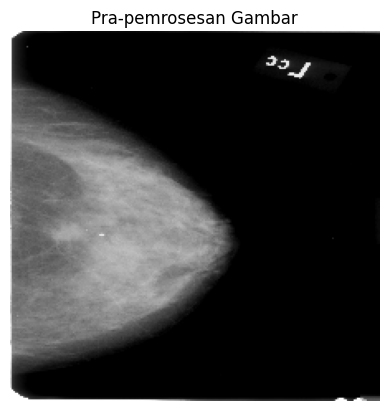

In [ ]:
# Ambil gambar pertama sebagai contoh
image_path = df['image file path'].iloc[0]

# Ekstrak nama folder dari jalur gambar
folder_name = os.path.basename(os.path.dirname(image_path))

# Susun jalur lengkap ke folder tempat gambar berada
image_dir = os.path.join('/content/CBIS-DDSM/jpeg', folder_name)

# Cek apakah folder gambar tersedia
if os.path.exists(image_dir):
    img_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    # Ambil file pertama untuk diproses
    full_image_path = os.path.join(image_dir, img_files[0])
    processed_image = preprocess_image(full_image_path)

    # Tampilkan hasil pra-pemrosesan
    if processed_image is not None:
        plt.imshow(processed_image, cmap='gray')
        plt.title("Pra-pemrosesan Gambar")
        plt.axis('off')
        plt.show()
else:
    print(f"Folder gambar tidak ditemukan: {image_dir}")

In [ ]:
all_images = []
labels = []

for idx, row in df.iterrows():
    # Ambil path gambar dan label
    rel_path = row['image file path']
    label = row['pathology']  # Misalnya: 'MALIGNANT' atau 'BENIGN'

    folder = os.path.basename(os.path.dirname(rel_path))
    image_dir = os.path.join('/content/CBIS-DDSM/jpeg', folder)

    if os.path.exists(image_dir):
        img_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

        if img_files:
            img_path = os.path.join(image_dir, img_files[0])  # Ambil satu gambar per kasus
            img = preprocess_image(img_path)

            if img is not None:
                all_images.append(img)
                labels.append(label)
    else:
        print(f"[SKIP] Direktori tidak ditemukan: {image_dir}")

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

X = np.array(all_images).reshape(-1, 224, 224, 1)  # Tambahkan channel (1) untuk grayscale
le = LabelEncoder()
y = le.fit_transform(labels)  # Ubah label string ke angka (0/1)

print(f"Dataset siap: X shape = {X.shape}, y shape = {y.shape}")


Dataset siap: X shape = (1318, 224, 224, 1), y shape = (1318,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator untuk augmentasi citra
datagen = ImageDataGenerator(
    rotation_range=20,        # rotasi citra
    width_shift_range=0.2,    # pergeseran lebar
    height_shift_range=0.2,   # pergeseran tinggi
    shear_range=0.2,          # shear (kemiringan)
    zoom_range=0.2,           # zoom in/zoom out
    horizontal_flip=True,     # flipping horizontal
    fill_mode='nearest'       # mengisi pixel kosong
)

# Fit data ke generator augmentasi
datagen.fit(X)

In [ ]:
from tensorflow.keras import layers, models

# Membuat model CNN
model = models.Sequential()

# Layer Convolutional untuk ekstraksi fitur
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())  # Rata-rata citra menjadi vektor
model.add(layers.Dense(128, activation='relu'))  # Fully connected layer

# Layer output untuk klasifikasi (2 kelas: Benign vs Malignant)
model.add(layers.Dense(1, activation='sigmoid'))

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data menjadi training dan validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat generator dari training data
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Training model dengan validation data secara terpisah
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.1045 - loss: -25.6767 - val_accuracy: 0.0871 - val_loss: -463.5585
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.0746 - loss: -287.0277 - val_accuracy: 0.0871 - val_loss: -3896.8928
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.0713 - loss: -7051.0186 - val_accuracy: 0.0871 - val_loss: -99204.1719
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.0838 - loss: -142722.7812 - val_accuracy: 0.0871 - val_loss: -613375.1250
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.0828 - loss: -800369.7500 - val_accuracy: 0.0871 - val_loss: -2697695.2500
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.0700 - loss: -1541622.0000 - val_accuracy: 0.0871 - val_loss: -6035793.5000
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.0716 - loss: -9793388.0000 - val_accuracy: 0.0871 - val_loss: -16892812.0000
Epoch 8/10
33/33 ━━━━━━━━━━━

In [ ]:
val_datagen = ImageDataGenerator()

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.0850 - loss: -121911592.0000 - val_accuracy: 0.0871 - val_loss: -238356848.0000
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.0855 - loss: -183347104.0000 - val_accuracy: 0.0871 - val_loss: -355460256.0000
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.0781 - loss: -260370864.0000 - val_accuracy: 0.0871 - val_loss: -574066880.0000
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.0703 - loss: -108900720.0000 - val_accuracy: 0.0871 - val_loss: -804742400.0000
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.0789 - loss: -808947648.0000 - val_accuracy: 0.0871 - val_loss: -1248491136.0000
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.0699 - loss: -961031232.0000 - val_accuracy: 0.0871 - val_loss: -1760121856.0000
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.0776 - loss: -1285471616.0000 - val_accuracy: 0.0871 - 

In [ ]:
# Evaluasi performa model pada data validasi
val_loss, val_acc = model.evaluate(val_generator)
print(f"Akurasi Validasi: {val_acc:.4f}, Loss: {val_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0980 - loss: -1359387264.0000
Akurasi Validasi: 0.0871, Loss: -4706405376.0000


In [ ]:
# Prediksi probabilitas
y_pred_prob = model.predict(val_generator)

# Konversi probabilitas menjadi label kelas (0: Benign, 1: Malignant)
y_pred_class = (y_pred_prob > 0.5).astype("int32").flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [ ]:
print("Unique labels in y_true:", np.unique(y_val))
print("Unique labels in y_pred_class:", np.unique(y_pred_class))

Unique labels in y_true: [0 1 2]
Unique labels in y_pred_class: [1]


In [ ]:
from sklearn.metrics import classification_report

# Hanya izinkan label 0 dan 1
valid_labels = [0, 1]

# Filter y_true dan y_pred_class agar hanya 0 dan 1
# Mengganti y_true dengan y_val karena y_val adalah label sebenarnya untuk data validasi
mask = np.isin(y_val, valid_labels) & np.isin(y_pred_class, valid_labels)
y_true_filtered = y_val[mask] # Mengganti y_true dengan y_val
y_pred_filtered = y_pred_class[mask]

# Cetak classification report
print(classification_report(
    y_true_filtered, y_pred_filtered,
    target_names=['Benign', 'Malignant'],
    zero_division=0  # hindari warning jika ada kelas yang tidak terprediksi
))

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       112
   Malignant       0.17      1.00      0.29        23

    accuracy                           0.17       135
   macro avg       0.09      0.50      0.15       135
weighted avg       0.03      0.17      0.05       135



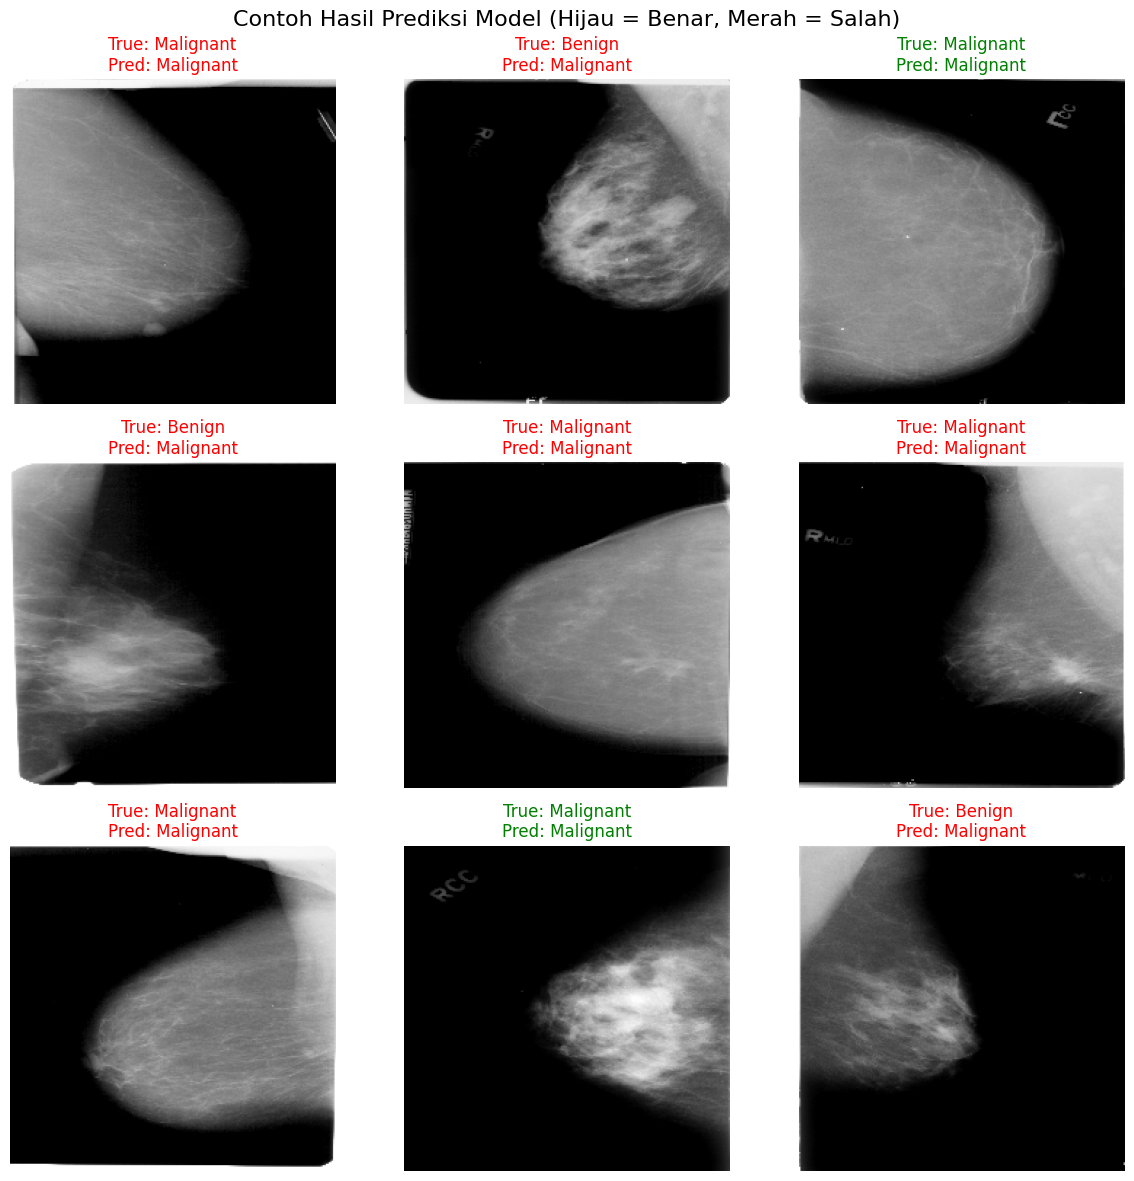

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Asumsikan X_val adalah input validasi (grayscale 224x224x1), y_val adalah label aslinya
# y_pred_class adalah hasil prediksi model (sudah dalam bentuk kelas 0 atau 1)

# Tampilkan 9 contoh hasil prediksi
num_images = 9
indices = np.random.choice(len(X_val), num_images, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)

    # Ambil gambar (squeeze channel untuk grayscale)
    img = X_val[idx].squeeze()

    true_label = y_val[idx]
    pred_label = y_pred_class[idx]

    # Tampilkan gambar
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {'Benign' if true_label==0 else 'Malignant'}\nPred: {'Benign' if pred_label==0 else 'Malignant'}",
              color='green' if true_label == pred_label else 'red')
    plt.axis('off')

plt.suptitle('Contoh Hasil Prediksi Model (Hijau = Benar, Merah = Salah)', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Perluas channel grayscale menjadi 3 (channel stacking)
X_rgb = np.repeat(X, 3, axis=-1)  # (224, 224, 1) -> (224, 224, 3)

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split

# Pisahkan data menjadi training dan validation set (misalnya 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_rgb, y, test_size=0.2, random_state=42)

# Membuat data generator untuk training dan validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk training dan validation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Membuat dan kompilasi model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_few_shot = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_few_shot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model
history_few_shot = model_few_shot.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 789ms/step - accuracy: 0.1171 - loss: -0.5870 - val_accuracy: 0.0871 - val_loss: -4.9379
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.0832 - loss: -3.9258 - val_accuracy: 0.0871 - val_loss: -9.2933
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.0850 - loss: -7.4723 - val_accuracy: 0.0871 - val_loss: -13.3342
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.0741 - loss: -5.9090 - val_accuracy: 0.0871 - val_loss: -20.2469
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.0715 - loss: -11.3044 - val_accuracy: 0.0871 - val_loss: -26.7895
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.0752 - loss: -9.4088 - val_accuracy: 0.0871 - val_loss: -34.4705
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.0751 - loss: -29.7778 - val_accuracy: 0.0871 - val_loss: -48.9305
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.0717 - loss: -36.5598 - va

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np # Make sure numpy is imported

# Assuming X_rgb and y are already defined from previous steps

# Split data into training and remaining set (validation + test)
X_train, X_rem, y_train, y_rem = train_test_split(X_rgb, y, test_size=0.3, random_state=42) # 30% for val+test

# Split the remaining set into validation and test sets
# This will be 0.5 * 0.3 = 0.15 of the original data for validation
# and 0.5 * 0.3 = 0.15 of the original data for test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

print(f"Dataset splits: Train = {X_train.shape[0]}, Validation = {X_val.shape[0]}, Test = {X_test.shape[0]}")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat data generator untuk training dan validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255) # Also create a generator for test data

# Membuat generator untuk training dan validation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False) # Shuffle=False is good for evaluation metrics

# The model creation and compilation code can remain the same:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models # Make sure layers and models are imported

# Membuat dan kompilasi model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_few_shot = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_few_shot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model (assuming you want to retrain the model after the split)
history_few_shot = model_few_shot.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Now the evaluation code using X_test and y_test should work:
# Melakukan prediksi pada data uji
y_pred = model_few_shot.predict(test_generator) # Predict on the test generator

# Mengubah probabilitas menjadi kelas (0 untuk Benign, 1 untuk Malignant)
y_pred_class = (y_pred > 0.5).astype("int32").flatten() # Flatten to match y_test shape

# Menampilkan hasil prediksi (contoh pertama)
print(f'Prediksi: {y_pred_class[0]} | Label asli: {y_test[0]}')

Dataset splits: Train = 922, Validation = 198, Test = 198
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.1190 - loss: 0.4633 - val_accuracy: 0.0859 - val_loss: -6.3079
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.0722 - loss: -0.6773 - val_accuracy: 0.0859 - val_loss: -8.3582
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.0808 - loss: -4.5347 - val_accuracy: 0.0859 - val_loss: -14.6008
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.0790 - loss: -8.4866 - val_accuracy: 0.0859 - val_loss: -21.7859
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.0738 - loss: 0.8724 - val_accuracy: 0.0859 - val_loss: -18.5806
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.0829 - loss: -0.6541 - val_accuracy: 0.0859 - val_loss: -20.5972
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.0735 - loss: -3.0031 - val_accuracy: 0.0859 - val_loss: -27.0324
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.0721 - loss: -11.5422 - val_acc

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        80
   Malignant       0.08      1.00      0.14        15

   micro avg       0.08      0.16      0.10        95
   macro avg       0.04      0.50      0.07        95
weighted avg       0.01      0.16      0.02        95



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


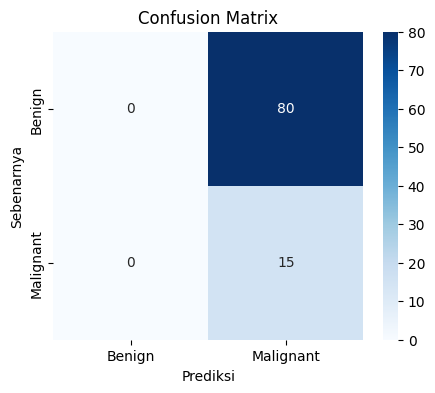

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported if not already

# Classification Report
# Explicitly specify the labels to consider (0 and 1)
print(classification_report(y_test, y_pred_class, target_names=['Benign', 'Malignant'], labels=[0, 1]))

# Confusion Matrix
# Explicitly specify the labels to consider for the confusion matrix
cm = confusion_matrix(y_test, y_pred_class, labels=[0, 1])

# Visualisasi Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

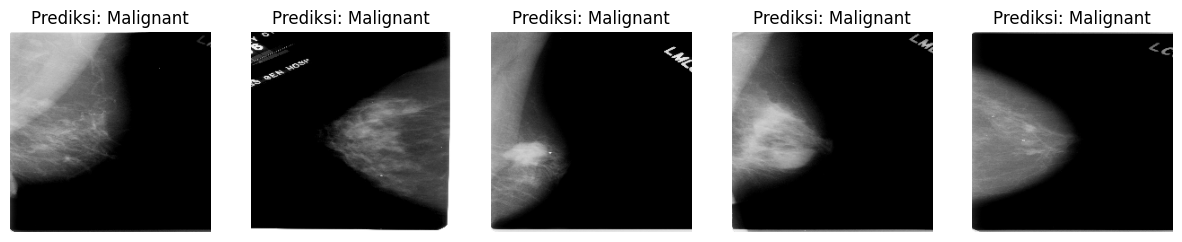

In [ ]:
# Visualisasi beberapa gambar dengan hasil prediksi
num_images = 5  # Misal menampilkan 5 gambar pertama

plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(X_test[i])  # Gambar asli
    plt.title(f'Prediksi: {"Malignant" if y_pred_class[i] == 1 else "Benign"}')
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Membuka beberapa layer dari base model untuk fine-tuning
base_model.trainable = True
fine_tune_at = 15  # Melatih layer setelah layer ke-15
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang model untuk fine-tuning
model_few_shot.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih ulang model (fine-tuning)
history_fine_tune = model_few_shot.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 341ms/step - accuracy: 0.0820 - loss: -4.1407 - val_accuracy: 0.0859 - val_loss: -47.4805
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.0851 - loss: 16.1373 - val_accuracy: 0.0859 - val_loss: -51.4148
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.0855 - loss: -16.2951 - val_accuracy: 0.0859 - val_loss: -59.5263
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.0671 - loss: -7.3812 - val_accuracy: 0.0859 - val_loss: -64.9448
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.0809 - loss: -38.8846 - val_accuracy: 0.0859 - val_loss: -72.3853


In [ ]:
# Melakukan evaluasi pada data uji setelah fine-tuning
y_pred_fine_tune = model_few_shot.predict(X_test)
# Reshape y_pred_fine_tune to match y_test shape for classification_report
y_pred_class_fine_tune = (y_pred_fine_tune > 0.5).astype("int32").flatten()

# Classification report setelah fine-tuning
# Explicitly specify the labels to be considered (0 and 1)
print(classification_report(y_test, y_pred_class_fine_tune, target_names=['Benign', 'Malignant'], labels=[0, 1]))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        80
   Malignant       0.08      1.00      0.14        15

   micro avg       0.08      0.16      0.10        95
   macro avg       0.04      0.50      0.07        95
weighted avg       0.01      0.16      0.02        95



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np # Make sure numpy is imported

# Load pre-trained model (misalnya VGG16) dan tambahkan layer khusus untuk klasifikasi kanker payudara
# Ensure input_shape has 3 channels for imagenet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Menambahkan custom layer untuk klasifikasi
model_few_shot = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output: 0 untuk Benign, 1 untuk Malignant
])

# Kompilasi model few-shot
model_few_shot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# You need to create a data generator that uses X_rgb
# Assuming X_rgb and y are already defined from previous steps
# It's better to split data into train/validation first before creating generator
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rgb, y, test_size=0.2, random_state=42)

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255) # Consider adding augmentation if needed
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


# Melatih model dengan data yang terbatas
history_few_shot = model_few_shot.fit(train_generator, epochs=10, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.1127 - loss: -0.4405 - val_accuracy: 0.0871 - val_loss: -6.4503
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.0742 - loss: -10.3878 - val_accuracy: 0.0871 - val_loss: -14.5198
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.0669 - loss: -10.2557 - val_accuracy: 0.0871 - val_loss: -21.5575
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.0882 - loss: -36.6772 - val_accuracy: 0.0871 - val_loss: -33.9412
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.0765 - loss: -38.5040 - val_accuracy: 0.0871 - val_loss: -39.8950
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.0850 - loss: -32.8829 - val_accuracy: 0.0871 - val_loss: -51.2109
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.0951 - loss: -33.9697 - val_accuracy: 0.0871 - val_loss: -66.6517
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.0798 - los